<a href="https://colab.research.google.com/github/Glorc12/30.11.2023-/blob/main/_accident_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Паралельное вычисление pandas
https://habr.com/ru/articles/498904/

# Установка необходимых библиотек
Данный этап предназначен для того, чтобы установить на наше устройство те библиотеки, которые нельзя просто импортировать



In [ ]:
!ookpip install requests bs4 lxml
!pip install noteb
!pip install folium
!pip install phik

/bin/bash: ookpip: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement noteb (from versions: none)
ERROR: No matching distribution found for noteb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 679 kB 5.5 MB/s 


# Импорт необходимых библиотек, методов и метрик
После того, как мы установили все необходимые библиотеки, мы можем приступить к импорту того, что будем использовать для решения поставленной задачи на протяжении всего проекта

In [ ]:
import requests
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None) # задаеться максимальное количество столбоцов а добавляя None мы обозначем что  будут отображаться все столбцы
sns.set(rc={'figure.figsize':(20,10)}) #настроика размера рисунка

In [ ]:
# Подключаем гугл диск для работы с файлами на нем
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Парсинг Данных (Загрузка данных)
Загрузку данных мы будем проводить с официального сайта ДТП России: https://dtp-stat.ru/opendata/. На данной странице нам предоставили 85 регионов, с которыми нам предстоит поработать. Для загрузки данных мы разработаем парсер, но первым делом давайте сохраним результат html страницы и потом преобразуем все методом BeautifulSoup:

In [ ]:
url = f'https://dtp-stat.ru/opendata/'
req = requests.get(url) # отправка запроса на получение данных
result = req.content

soup = BeautifulSoup(result, 'lxml')  # анализ веб-страницы

Все данные сохранены в объекте супа - пора приступить к поиску ссылок каждого региона. Сделаем это с помощью методов find_all (найдем все теги с определенным классом) и get (получим результат по переменной). Все ссылки, которые мы найдем мы вложим в список. Поиск кнопок будем осуществлять в цикле (не берем первый элемент, так как первая кнопка - "Поддержать проект"):

In [ ]:
urls_list = []
for tag in soup.find_all('a', 'button')[1:]:
    urls_tail = tag.get('href')
    urls_list.append(urls_tail)

После создания списка со всеми ссылками, мы можем начать загружать данные из ссылок и вводить их в единый датасет. Так как работа совершается на локальной машине с ограниченными мощностями, было решено взять не все данные, а лишь часть (5 регионов):

In [ ]:
urls_list

['https://cms.dtp-stat.ru/media/opendata/altaiskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/amurskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/arkhangelskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/astrakhanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/belgorodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/brianskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vladimirskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/volgogradskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vologodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/voronezhskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/evreiskaia-avtonomnaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/zabaikalskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/ivanovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/irkutskaia-oblast.geojson',
 '

['https://cms.dtp-stat.ru/media/opendata/altaiskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/amurskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/arkhangelskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/astrakhanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/belgorodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/brianskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vladimirskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/volgogradskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/vologodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/voronezhskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/evreiskaia-avtonomnaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/zabaikalskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/ivanovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/irkutskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kabardino-balkarskaia-respublika.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kaliningradskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kaluzhskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kamchatskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/karachaevo-cherkesskaia-respublika.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kemerovskaia-oblast-kuzbass.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kirovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kostromskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/krasnodarskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/krasnoiarskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kurganskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/kurskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/leningradskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/lipetskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/magadanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/moskva.geojson',
 'https://cms.dtp-stat.ru/media/opendata/moskovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/murmanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/nenetskii-avtonomnyi-okrug.geojson',
 'https://cms.dtp-stat.ru/media/opendata/nizhegorodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/novgorodskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/novosibirskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/omskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/orenburgskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/orlovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/penzenskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/permskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/primorskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/pskovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-adygeia-adygeia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-altai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-bashkortostan.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-buriatiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-dagestan.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-ingushetiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-kalmykiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-kareliia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-komi.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-krym.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-marii-el.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-mordoviia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-sakha-iakutiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-severnaia-osetiia-alaniia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-tatarstan-tatarstan.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-tyva.geojson',
 'https://cms.dtp-stat.ru/media/opendata/respublika-khakasiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/rostovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/riazanskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/samarskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/sankt-peterburg.geojson',
 'https://cms.dtp-stat.ru/media/opendata/saratovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/sakhalinskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/sverdlovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/sevastopol.geojson',
 'https://cms.dtp-stat.ru/media/opendata/smolenskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/stavropolskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/tambovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/tverskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/tomskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/tulskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/tiumenskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/udmurtskaia-respublika.geojson',
 'https://cms.dtp-stat.ru/media/opendata/ulianovskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/khabarovskii-krai.geojson',
 'https://cms.dtp-stat.ru/media/opendata/khanty-mansiiskii-avtonomnyi-okrug-iugra.geojson',
 'https://cms.dtp-stat.ru/media/opendata/cheliabinskaia-oblast.geojson',
 'https://cms.dtp-stat.ru/media/opendata/chechenskaia-respublika.geojson',
 'https://cms.dtp-stat.ru/media/opendata/chuvashskaia-respublika-chuvashiia.geojson',
 'https://cms.dtp-stat.ru/media/opendata/chukotskii-avtonomnyi-okrug.geojson',
 'https://cms.dtp-stat.ru/media/opendata/iamalo-nenetskii-avtonomnyi-okrug.geojson',
 'https://cms.dtp-stat.ru/media/opendata/iaroslavskaia-oblast.geojson',
 '/donate/',
 'https://twitter.com/dtp_stat',
 'https://t.me/dtp_stat']

In [ ]:
len(urls_list)

88

In [ ]:
def take_info_from_list(val_list): # val_list-список_значений
    val_str = ', ' # Преобразует целочисленное значение в строку.
    if len(val_list) == 0:
        return 'Нету информации'
    else:
        return val_str.join(val_list) # Метод str.join() возвращает строку, которая является конкатенацией (объединением) всех строк-элементов итерируемого объекта iterable

## Парсинг общих данных

In [ ]:
# Это были тесты на данных по 5 регионам
# total_data = pd.DataFrame()
# #  последние три кнопки в списке ссылок - кнопки поддержать проект, карта ДТП в twitter и карта ДТП в telegram
# for url in tqdm(urls_list[:-83]):
#     data = pd.read_json(url)
#     new_data = pd.DataFrame(list(data['features']))
#     last_data = pd.DataFrame(list(new_data['properties']))
#     total_data = pd.concat([total_data, last_data])

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
total_data = pd.DataFrame()
#  последние три кнопки в списке ссылок - кнопки поддержать проект, карта ДТП в twitter и карта ДТП в telegram
for url in tqdm(urls_list[:-3]):
    data = pd.read_json(url) #JSON = словарь Python
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data = pd.concat([total_data, last_data])

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
total_data.head()

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,[Дорожно-транспортные происшествия],"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","[Многоквартирные жилые дома, Административные ...",Барнаул,610,"г Барнаул, тракт Павловский, 249 а",[Ясно],Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,[Сухое],2,[Все участники]
1,2589161,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 53.3697, 'long': 83.7092}","[Остановка общественного транспорта, Нерегулир...",Барнаул,070,"г Барнаул, ул Малахова, 46",[Ясно],Столкновение,2021-06-29 16:45:00,Легкий,"[{'year': 2014, 'brand': 'MITSUBISHI', 'color'...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,[Все участники]
2,2577125,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 53.264995, 'long': 83.725905}","[Жилые дома индивидуальной застройки, Админист...",Барнаул,940,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",[Ясно],Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,"[{'year': 2002, 'brand': 'HONDA', 'color': 'Же...",0,[],1,Алтайский край,[Сухое],1,"[Все участники, Мотоциклисты]"
3,2576909,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 53.3764, 'long': 83.7142}","[Выезд с прилегающей территории, Административ...",Барнаул,130,"г Барнаул, ул Петра Сухова, 83 А",[Ясно],Столкновение,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",3,"[Все участники, Мотоциклисты]"
4,2575209,[Дорожно-транспортные происшествия],Светлое время суток,"{'lat': 53.343071, 'long': 83.794366}","[Многоквартирные жилые дома, Жилые дома индиви...",Барнаул,500,"г Барнаул, ул Партизанская, 26",[Ясно],Столкновение,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"[Сухое, Отсутствие, плохая различимость горизо...",2,[Все участники]


In [ ]:
total_data.shape

(1242833, 20)

Данные в таблицу прогружены и мы видим некоторые недочеты:

словари в некоторых столбцах: point, vehicles, participants
списки в некоторых столбцах: tags, nearby, weather, vehicles, participants, road_conditions, participant_categories
неопознанный столбец scheme
После просмотра первых строк датасета, мы приступаем к проверке типов столбцов и количеству пропусков в них:

In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242833 entries, 0 to 14035
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   id                      1242833 non-null  int64 
 1   tags                    1242833 non-null  object
 2   light                   1242833 non-null  object
 3   point                   1242833 non-null  object
 4   nearby                  1242833 non-null  object
 5   region                  1242833 non-null  object
 6   scheme                  1169237 non-null  object
 7   address                 1187255 non-null  object
 8   weather                 1242833 non-null  object
 9   category                1242833 non-null  object
 10  datetime                1242833 non-null  object
 11  severity                1242833 non-null  object
 12  vehicles                1242833 non-null  object
 13  dead_count              1242833 non-null  int64 
 14  participants        

Неверные типы данных замечены в:

datetime

Пропуски в данных замечены в:

scheme
address

Исходя из того, что мы имеем, можно приступить к предобработке данных

Потому что датасет долго обрабатывает файлы мы будем переодические его сохранять кусочками, чтобы продолжать не с самого начала, так как много данных

In [ ]:
# Save our new dataset
from google.colab import files
total_data.to_csv("total_data.csv", index=False)
files.download("total_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Предобработка данных и выделение значимых атрибутов

In [ ]:
total_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/total_data.csv')

In [ ]:
total_data

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","Многоквартирные жилые дома, Административные з...",Барнаул,610.0,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,"[{'year': 2002, 'brand': 'TOYOTA', 'color': 'Ч...",0,[],1,Алтайский край,Сухое,2,Все участники
1,2589161,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3697, 'long': 83.7092}","Остановка общественного транспорта, Нерегулиру...",Барнаул,70.0,"г Барнаул, ул Малахова, 46",Ясно,Столкновение,2021-06-29 16:45:00,Легкий,"[{'year': 2014, 'brand': 'MITSUBISHI', 'color'...",0,[],1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,Все участники
2,2577125,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","{'lat': 53.264995, 'long': 83.725905}","Жилые дома индивидуальной застройки, Администр...",Барнаул,940.0,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",Ясно,Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,"[{'year': 2002, 'brand': 'HONDA', 'color': 'Же...",0,[],1,Алтайский край,Сухое,1,"Все участники, Мотоциклисты"
3,2576909,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3764, 'long': 83.7142}","Выезд с прилегающей территории, Административн...",Барнаул,130.0,"г Барнаул, ул Петра Сухова, 83 А",Ясно,Столкновение,2021-05-29 19:40:00,Тяжёлый,"[{'year': 2001, 'brand': 'HONDA', 'color': 'Се...",0,[],1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,"Все участники, Мотоциклисты"
4,2575209,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.343071, 'long': 83.794366}","Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,500.0,"г Барнаул, ул Партизанская, 26",Ясно,Столкновение,2021-05-25 16:40:00,Легкий,"[{'year': 2014, 'brand': 'NISSAN', 'color': 'С...",0,[],1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,Все участники
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242828,1871505,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 57.419191, 'long': 39.105191}",Нету информации,Борисоглебский район,NaN,"ВОЩАЖНИКОВО-ВЕСКА-ЗАДУБРОВЬЕ, 1 км",Ясно,Съезд с дороги,2019-06-17 14:00:00,Тяжёлый,"[{'year': 2013, 'brand': 'Прочие марки мотоцик...",0,[],1,Ярославская область,Сухое,1,"Мотоциклисты, Все участники"
1242829,1872990,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,"{'lat': 57.4142, 'long': 39.2}",Нету информации,Борисоглебский район,610.0,"ЮРКИНО-РАМЕНЬЕ, 2 км",Ясно,Съезд с дороги,2016-04-15 17:00:00,Тяжёлый,"[{'year': 1999, 'brand': 'МОСКВИЧ', 'color': '...",0,[],2,Ярославская область,Сухое,6,"Дети, Все участники"
1242830,1867222,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 57.230133, 'long': 39.213767}",Нету информации,Борисоглебский район,10.0,"УГЛИЧ-РОСТОВ, 76 км",Ясно,Столкновение,2019-07-13 19:30:00,Легкий,"[{'year': 1989, 'brand': 'ГАЗ', 'color': 'Белы...",0,[],2,Ярославская область,Сухое,2,Все участники
1242831,1874000,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 57.3161, 'long': 39.0047}",Нету информации,Борисоглебский район,600.0,"БОРИСОГЛЕБ-ЗАЧАТЬЕ, 1 км",Ясно,Опрокидывание,2018-08-15 17:00:00,Тяжёлый,"[{'year': 2014, 'brand': 'УАЗ', 'color': 'Иные...",0,[],1,Ярославская область,Сухое,1,Все участники


Удалим те столбцы, с которыми мы не будем работать: scheme, vehicles, participants. Почему именно с ними? Потому что столбец scheme неопознан, его нет в описании к признакам; vehicles - информация в данном столбце никак не поможет нам решить задачу; participants - данная информация также не поможет нам в решении задачи.

In [ ]:
total = total_data.drop(['scheme', 'vehicles', 'participants'], axis=1)
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242833 entries, 0 to 1242832
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   id                      1242833 non-null  int64 
 1   tags                    1242833 non-null  object
 2   light                   1242833 non-null  object
 3   point                   1242833 non-null  object
 4   nearby                  1242833 non-null  object
 5   region                  1242833 non-null  object
 6   address                 1187255 non-null  object
 7   weather                 1242833 non-null  object
 8   category                1242833 non-null  object
 9   datetime                1242833 non-null  object
 10  severity                1242833 non-null  object
 11  dead_count              1242833 non-null  int64 
 12  injured_count           1242833 non-null  int64 
 13  parent_region           1242833 non-null  object
 14  road_conditions   

Так как у нас много столбцов с данными, которые находятся в виде списка, то можно создать функцию, которая преобразует все в нормальный вид, а если там пустые скобки, то вернет текст - "Нету информации":

In [ ]:
def take_info_from_list(val_list):
    val_str = ', '
    if len(val_list) == 0:
        return 'Нету информации'
    else:
        return val_str.join(val_list)

Применим функцию ко всем столбцам со скобками:

In [ ]:
total['tags'] = total['tags'].apply(take_info_from_list)
total['nearby'] = total['nearby'].apply(take_info_from_list)
total['weather'] = total['weather'].apply(take_info_from_list)
total['road_conditions'] = total['road_conditions'].apply(take_info_from_list)
total['participant_categories'] = total['participant_categories'].apply(take_info_from_list)

In [ ]:
total.head()

,id,tags,light,point,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,['Дорожно-транспортные происшествия'],"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","['Многоквартирные жилые дома', 'Административн...",Барнаул,"г Барнаул, тракт Павловский, 249 а",['Ясно'],Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,['Сухое'],2,['Все участники']
1,2589161,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.3697, 'long': 83.7092}","['Остановка общественного транспорта', 'Нерегу...",Барнаул,"г Барнаул, ул Малахова, 46",['Ясно'],Столкновение,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,"['Сухое', 'Отсутствие, плохая различимость гор...",3,['Все участники']
2,2577125,['Дорожно-транспортные происшествия'],"В темное время суток, освещение включено","{'lat': 53.264995, 'long': 83.725905}","['Жилые дома индивидуальной застройки', 'Админ...",Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",['Ясно'],Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,['Сухое'],1,"['Все участники', 'Мотоциклисты']"
3,2576909,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.3764, 'long': 83.7142}","['Выезд с прилегающей территории', 'Администра...",Барнаул,"г Барнаул, ул Петра Сухова, 83 А",['Ясно'],Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"['Сухое', 'Отсутствие, плохая различимость гор...",3,"['Все участники', 'Мотоциклисты']"
4,2575209,['Дорожно-транспортные происшествия'],Светлое время суток,"{'lat': 53.343071, 'long': 83.794366}","['Многоквартирные жилые дома', 'Жилые дома инд...",Барнаул,"г Барнаул, ул Партизанская, 26",['Ясно'],Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"['Сухое', 'Отсутствие, плохая различимость гор...",2,['Все участники']


In [ ]:
total.reset_index(drop=True, inplace=True)

In [ ]:
# Save our new dataset
from google.colab import files
total.to_csv("total.csv", index=False)
files.download("total.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Вытаскиваем данные из столбца point

Как можно заметить, все скобки расскрыты и приведены в нормальный вид.

Следующий шаг - вытащить данные из столбца point и сохранить в нашу таблицу как значения столбцов, которые равны ключам словаря, хранящийся там. Для этого создадим отдельный список, который будет хранить все значения данного столбца. Если мы найдем пропуски в данных, то мы их заполним NaN:

Так как объем данных большой разбиваем его на 10 переменных, которые мы прогоним по очереди по нашей функции, чтобы провести их заполнение

### DataPoints1

In [ ]:
total_data_1 = pd.DataFrame()
for url in tqdm(urls_list[:8]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_1 = pd.concat([total_data_1, last_data])
total_data_1=total_data_1.drop(['scheme', 'vehicles', 'participants'], axis=1)

In [ ]:
total_data_1['tags'] = total_data_1['tags'].apply(take_info_from_list)
total_data_1['nearby'] = total_data_1['nearby'].apply(take_info_from_list)
total_data_1['weather'] = total_data_1['weather'].apply(take_info_from_list)
total_data_1['road_conditions'] = total_data_1['road_conditions'].apply(take_info_from_list)
total_data_1['participant_categories'] = total_data_1['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_1.shape[0])):
  try:
    danger.append(list(total_data_1['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/106438 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([53.342, 83.6903]),
 dict_values([53.3697, 83.7092]),
 dict_values([53.264995, 83.725905]),
 dict_values([53.3764, 83.7142]),
 dict_values([53.343071, 83.794366]),
 dict_values([53.380807, 83.690007]),
 dict_values([53.367244, 83.70904]),
 dict_values([53.376429, 83.718932]),
 dict_values([53.360707, 83.732353]),
 dict_values([53.290476, 83.708739]),
 dict_values([53.343378, 83.762727]),
 dict_values([53.367775, 83.74467]),
 dict_values([53.362974, 83.770301]),
 dict_values([53.3397, 83.6881]),
 dict_values([53.357051, 83.658732]),
 dict_values([53.337799, 83.774453]),
 dict_values([53.343391, 83.704684]),
 dict_values([53.25902, 83.722236]),
 dict_values([53.349924, 83.762062]),
 dict_values([53.350103, 83.607974]),
 dict_values([53.348547, 83.776696]),
 dict_values([53.3397, 83.7856]),
 dict_values([53.379303, 83.724564]),
 dict_values([53.362231, 83.745743]),
 dict_values([53.380602, 83.688548]),
 dict_values([53.336613, 83.663785]),
 dict_values([53.335281, 83.777307])

In [ ]:
data_points_1 = pd.DataFrame(columns=list(total_data_1['point'])[0].keys(), data=danger)

In [ ]:
data_points_1

,lat,long
0,53.342000,83.690300
1,53.369700,83.709200
2,53.264995,83.725905
3,53.376400,83.714200
4,53.343071,83.794366
...,...,...
106433,48.767695,44.787730
106434,48.775120,44.750694
106435,48.817815,44.750426
106436,48.816840,44.724441


In [ ]:
# Save our new dataset
from google.colab import files
data_points_1.to_csv("data_points_1.csv", index=False)
files.download("data_points_1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints2

In [ ]:
total_data_2 = pd.DataFrame()
for url in tqdm(urls_list[8:16]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_2 = pd.concat([total_data_2, last_data])
total_data_2=total_data_2.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_2['tags'] = total_data_2['tags'].apply(take_info_from_list)
total_data_2['nearby'] = total_data_2['nearby'].apply(take_info_from_list)
total_data_2['weather'] = total_data_2['weather'].apply(take_info_from_list)
total_data_2['road_conditions'] = total_data_2['road_conditions'].apply(take_info_from_list)
total_data_2['participant_categories'] = total_data_2['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_2.shape[0])):
  try:
    danger.append(list(total_data_2['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/94480 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([59.283641, 38.015764]),
 dict_values([59.9227, 37.228]),
 dict_values([59.1954, 37.6034]),
 dict_values([59.6512, 37.637]),
 dict_values([59.9323, 37.1377]),
 dict_values([59.14151, 37.59354]),
 dict_values([59.300735, 37.975552]),
 dict_values([59.1713, 37.5052]),
 dict_values([59.257562, 37.968632]),
 dict_values([59.46381, 37.7425]),
 dict_values([59.0399, 37.9672]),
 dict_values([58.59761, 37.25863]),
 dict_values([59.016405, 37.368965]),
 dict_values([59.194263, 37.665253]),
 dict_values([59.451576, 37.856784]),
 dict_values([59.18192, 37.532237]),
 dict_values([59.142692, 37.591083]),
 dict_values([59.097802, 37.398373]),
 dict_values([59.044175, 37.962914]),
 dict_values([59.19417, 37.692482]),
 dict_values([59.25839, 37.964298]),
 dict_values([59.293066, 38.053465]),
 dict_values([59.20469, 37.866]),
 dict_values([58.953151, 38.80517]),
 dict_values([59.505497, 37.981796]),
 dict_values([59.19473, 37.652721]),
 dict_values([59.29999, 38.105392]),
 dict_values([59.

In [ ]:
data_points_2 = pd.DataFrame(columns=list(total_data_2['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_2.to_csv("data_points_2.csv", index=False)
files.download("data_points_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints3

In [ ]:
total_data_3 = pd.DataFrame()
for url in tqdm(urls_list[16:24]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_3 = pd.concat([total_data_3, last_data])
total_data_3=total_data_3.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_3['tags'] = total_data_3['tags'].apply(take_info_from_list)
total_data_3['nearby'] = total_data_3['nearby'].apply(take_info_from_list)
total_data_3['weather'] = total_data_3['weather'].apply(take_info_from_list)
total_data_3['road_conditions'] = total_data_3['road_conditions'].apply(take_info_from_list)
total_data_3['participant_categories'] = total_data_3['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_3.shape[0])):
  try:
    danger.append(list(total_data_3['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/138955 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([55.107222, 36.642222]),
 dict_values([55.15253, 36.2681]),
 dict_values([55.129054, 36.586618]),
 dict_values([55.114495, 36.600995]),
 dict_values([55.12438, 36.580396]),
 dict_values([55.105063, 36.641271]),
 dict_values([55.107585, 36.64243]),
 dict_values([55.116557, 36.597873]),
 dict_values([55.273889, 36.236944]),
 dict_values([55.1253, 36.6153]),
 dict_values([55.6245, 36.127864]),
 dict_values([55.108463, 36.591361]),
 dict_values([55.123056, 36.588889]),
 dict_values([55.100999, 36.639351]),
 dict_values([55.104602, 36.596864]),
 dict_values([55.2031, 36.1867]),
 dict_values([55.541, 36.141]),
 dict_values([55.103848, 36.614985]),
 dict_values([55.6351, 36.3836]),
 dict_values([55.3506, 36.9881]),
 dict_values([55.108463, 36.591146]),
 dict_values([55.1008, 36.6394]),
 dict_values([55.101619, 36.601199]),
 dict_values([55.095726, 36.61756]),
 dict_values([55.103492, 36.609728]),
 dict_values([55.118993, 36.60078]),
 dict_values([55.102816, 36.615897]),
 dict_val

In [ ]:
data_points_3 = pd.DataFrame(columns=list(total_data_3['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_3.to_csv("data_points_3.csv", index=False)
files.download("data_points_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints4

In [ ]:
total_data_4 = pd.DataFrame()
for url in tqdm(urls_list[24:32]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_4 = pd.concat([total_data_4, last_data])
total_data_4=total_data_4.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_4['tags'] = total_data_4['tags'].apply(take_info_from_list)
total_data_4['nearby'] = total_data_4['nearby'].apply(take_info_from_list)
total_data_4['weather'] = total_data_4['weather'].apply(take_info_from_list)
total_data_4['road_conditions'] = total_data_4['road_conditions'].apply(take_info_from_list)
total_data_4['participant_categories'] = total_data_4['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_4.shape[0])):
  try:
    danger.append(list(total_data_4['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/177680 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([56.033829, 63.334036]),
 dict_values([56.095598, 63.508605]),
 dict_values([56.371905, 63.750443]),
 dict_values([55.939407, 63.383346]),
 dict_values([56.110665, 64.361054]),
 dict_values([56.13464, 63.609027]),
 dict_values([56.237662, 63.557367]),
 dict_values([56.077281, 63.895841]),
 dict_values([56.140582, 63.581947]),
 dict_values([56.200593, 63.248806]),
 dict_values([56.104478, 64.055443]),
 dict_values([56.234287, 63.453287]),
 dict_values([56.081328, 63.989868]),
 dict_values([56.383044, 63.739393]),
 dict_values([56.059901, 63.578289]),
 dict_values([56.085806, 63.477416]),
 dict_values([55.58, 63.37]),
 dict_values([56.155876, 63.381844]),
 dict_values([56.131854, 63.375514]),
 dict_values([56.059985, 63.580198]),
 dict_values([56.062501, 63.549042]),
 dict_values([56.019446, 63.652972]),
 dict_values([56.350795, 63.763597]),
 dict_values([56.10084, 63.834021]),
 dict_values([55.985611, 63.463093]),
 dict_values([56.21, 63.46]),
 dict_values([56.043473, 63.54

In [ ]:
data_points_4 = pd.DataFrame(columns=list(total_data_4['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_4.to_csv("data_points_4.csv", index=False)
files.download("data_points_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints5

In [ ]:
total_data_5 = pd.DataFrame()
for url in tqdm(urls_list[32:40]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_5 = pd.concat([total_data_5, last_data])
total_data_5=total_data_5.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_5['tags'] = total_data_5['tags'].apply(take_info_from_list)
total_data_5['nearby'] = total_data_5['nearby'].apply(take_info_from_list)
total_data_5['weather'] = total_data_5['weather'].apply(take_info_from_list)
total_data_5['road_conditions'] = total_data_5['road_conditions'].apply(take_info_from_list)
total_data_5['participant_categories'] = total_data_5['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_5.shape[0])):
  try:
    danger.append(list(total_data_5['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/125438 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([67.66785899999999, 53.103822]),
 dict_values([67.6666, 53.111397]),
 dict_values([67.192166, 56.667137]),
 dict_values([67.193771, 56.498694]),
 dict_values([67.639619, 52.976418]),
 dict_values([67.653941, 53.051348]),
 dict_values([67.933235, 53.969736]),
 dict_values([67.315628, 55.948467]),
 dict_values([67.666207, 53.074821]),
 dict_values([67.66054, 53.06772]),
 dict_values([67.664541, 53.123317]),
 dict_values([67.64681, 53.045779]),
 dict_values([67.667566, 53.12645]),
 dict_values([67.242043, 56.245752]),
 dict_values([67.636811, 52.985762]),
 dict_values([67.642982, 53.043001]),
 dict_values([67.6419, 53.0461]),
 dict_values([67.657788, 53.056744]),
 dict_values([67.666995, 53.087225]),
 dict_values([66.732308, 47.746153]),
 dict_values([67.669751, 53.128413]),
 dict_values([67.6264, 53.2528]),
 dict_values([67.613274, 53.0992]),
 dict_values([67.657518, 49.033366]),
 dict_values([67.671952, 53.104005]),
 dict_values([68.3447, 58.3822]),
 dict_values([68.658117,

In [ ]:
data_points_5 = pd.DataFrame(columns=list(total_data_5['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_5.to_csv("data_points_5.csv", index=False)
files.download("data_points_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints6

In [ ]:
total_data_6 = pd.DataFrame()
for url in tqdm(urls_list[40:48]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_6 = pd.concat([total_data_6, last_data])
total_data_6=total_data_6.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_6['tags'] = total_data_6['tags'].apply(take_info_from_list)
total_data_6['nearby'] = total_data_6['nearby'].apply(take_info_from_list)
total_data_6['weather'] = total_data_6['weather'].apply(take_info_from_list)
total_data_6['road_conditions'] = total_data_6['road_conditions'].apply(take_info_from_list)
total_data_6['participant_categories'] = total_data_6['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_6.shape[0])):
  try:
    danger.append(list(total_data_6['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/114080 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([59.029989, 54.952358]),
 dict_values([59.073963, 56.12576]),
 dict_values([59.013444, 55.832369]),
 dict_values([59.013367, 55.832498]),
 dict_values([59.003594, 55.875424]),
 dict_values([58.977931, 54.846411]),
 dict_values([58.9703, 54.958463]),
 dict_values([59.050543, 55.008781]),
 dict_values([58.977954, 54.911063]),
 dict_values([None, None]),
 dict_values([58.91597, 54.888897]),
 dict_values([59.006003, 55.855769]),
 dict_values([59.093708, 55.429437]),
 dict_values([59.005396, 55.942211]),
 dict_values([59.02287, 55.53453]),
 dict_values([59.013358, 55.829687]),
 dict_values([59.004307, 55.86818]),
 dict_values([59.009898, 54.935632]),
 dict_values([None, None]),
 dict_values([59.003014, 55.881228]),
 dict_values([58.991155, 55.584297]),
 dict_values([None, None]),
 dict_values([58.990069, 55.61108]),
 dict_values([59.0286, 54.9433]),
 dict_values([58.9964, 55.4439]),
 dict_values([59.030033, 54.953098]),
 dict_values([59.076565, 56.103895]),
 dict_values([None, 

In [ ]:
data_points_6 = pd.DataFrame(columns=list(total_data_6['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_6.to_csv("data_points_6.csv", index=False)
files.download("data_points_6.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints7

In [ ]:
total_data_7 = pd.DataFrame()
for url in tqdm(urls_list[48:56]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_7 = pd.concat([total_data_7, last_data])
total_data_7=total_data_7.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_7['tags'] = total_data_7['tags'].apply(take_info_from_list)
total_data_7['nearby'] = total_data_7['nearby'].apply(take_info_from_list)
total_data_7['weather'] = total_data_7['weather'].apply(take_info_from_list)
total_data_7['road_conditions'] = total_data_7['road_conditions'].apply(take_info_from_list)
total_data_7['participant_categories'] = total_data_7['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_7.shape[0])):
  try:
    danger.append(list(total_data_7['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/53510 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([43.461735, 44.760725]),
 dict_values([43.502192, 44.586961]),
 dict_values([43.479293, 44.641796]),
 dict_values([43.479713, 44.76506]),
 dict_values([43.402366, 44.756477]),
 dict_values([43.479441, 44.652321]),
 dict_values([43.512222, 44.597347]),
 dict_values([43.510355, 44.585363]),
 dict_values([43.345842, 44.695301]),
 dict_values([43.49553, 44.581468]),
 dict_values([43.511841, 44.585953]),
 dict_values([43.49546, 44.581382]),
 dict_values([43.509958, 44.582273]),
 dict_values([43.518711, 44.585277]),
 dict_values([43.507686, 44.584858]),
 dict_values([43.512487, 44.595416]),
 dict_values([43.522912, 44.53042]),
 dict_values([43.502963, 44.583453]),
 dict_values([43.398765, 44.753537]),
 dict_values([43.497429, 44.601692]),
 dict_values([43.371443, 44.736103]),
 dict_values([43.511849, 44.585931]),
 dict_values([43.330212, 44.688671]),
 dict_values([43.5082, 44.584816000000004]),
 dict_values([43.50297, 44.583389]),
 dict_values([43.502963, 44.583421]),
 dict_valu

In [ ]:
data_points_7 = pd.DataFrame(columns=list(total_data_7['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_7.to_csv("data_points_7.csv", index=False)
files.download("data_points_7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("data_points_7.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints8

In [ ]:
total_data_8 = pd.DataFrame()
for url in tqdm(urls_list[56:64]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_8 = pd.concat([total_data_8, last_data])
total_data_8=total_data_8.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_8['tags'] = total_data_8['tags'].apply(take_info_from_list)
total_data_8['nearby'] = total_data_8['nearby'].apply(take_info_from_list)
total_data_8['weather'] = total_data_8['weather'].apply(take_info_from_list)
total_data_8['road_conditions'] = total_data_8['road_conditions'].apply(take_info_from_list)
total_data_8['participant_categories'] = total_data_8['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_8.shape[0])):
  try:
    danger.append(list(total_data_8['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/165613 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([43.033208, 44.68528]),
 dict_values([43.04439, 44.628257]),
 dict_values([43.028777, 44.671483]),
 dict_values([43.035435, 44.667331]),
 dict_values([43.021851, 44.697533]),
 dict_values([43.036392, 44.656098]),
 dict_values([43.029451, 44.636292]),
 dict_values([42.996926, 44.654574]),
 dict_values([43.053587, 44.675378]),
 dict_values([43.038062, 44.682491]),
 dict_values([43.054535, 44.667771]),
 dict_values([43.032447, 44.707661]),
 dict_values([43.045433, 44.657879]),
 dict_values([43.033482, 44.668565]),
 dict_values([43.028557, 44.659832]),
 dict_values([43.001705, 44.652922]),
 dict_values([43.040367, 44.658973]),
 dict_values([43.048443, 44.690151]),
 dict_values([43.039583, 44.66187]),
 dict_values([43.075816, 44.656806]),
 dict_values([43.014838, 44.670185]),
 dict_values([43.049635, 44.675399]),
 dict_values([43.057467, 44.643223]),
 dict_values([43.029482, 44.689207]),
 dict_values([42.991621, 44.657729]),
 dict_values([43.04791, 44.63316]),
 dict_values([43.

In [ ]:
data_points_8 = pd.DataFrame(columns=list(total_data_8['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_8.to_csv("data_points_8.csv", index=False)
files.download("data_points_8.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints9

In [ ]:
total_data_9 = pd.DataFrame()
for url in tqdm(urls_list[64:72]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_9 = pd.concat([total_data_9, last_data])
total_data_9=total_data_9.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
total_data_9['tags'] = total_data_9['tags'].apply(take_info_from_list)
total_data_9['nearby'] = total_data_9['nearby'].apply(take_info_from_list)
total_data_9['weather'] = total_data_9['weather'].apply(take_info_from_list)
total_data_9['road_conditions'] = total_data_9['road_conditions'].apply(take_info_from_list)
total_data_9['participant_categories'] = total_data_9['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_9.shape[0])):
  try:
    danger.append(list(total_data_9['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/111540 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([52.484701, 48.109303]),
 dict_values([52.411425, 48.005104]),
 dict_values([52.561899, 48.089862]),
 dict_values([52.634313, 48.186593]),
 dict_values([52.495389, 48.098831]),
 dict_values([52.33492, 47.9282]),
 dict_values([52.411857, 48.111749]),
 dict_values([52.413676, 48.006563]),
 dict_values([52.335129, 47.928629]),
 dict_values([52.748568, 48.24985]),
 dict_values([52.484427, 48.106427]),
 dict_values([52.533663, 48.035831]),
 dict_values([52.296302, 47.928286]),
 dict_values([52.296538, 47.928243]),
 dict_values([52.277821, 47.931418]),
 dict_values([52.388435, 47.975299]),
 dict_values([52.309686, 47.924767]),
 dict_values([52.506805, 48.067321]),
 dict_values([52.294524, 48.012979]),
 dict_values([52.4968, 48.014481]),
 dict_values([52.412675, 48.005909]),
 dict_values([52.495826, 48.109667]),
 dict_values([52.6987, 48.1833]),
 dict_values([52.613837, 48.162882]),
 dict_values([51.987778, 47.824167]),
 dict_values([52.478436, 48.107224]),
 dict_values([52.29218

In [ ]:
data_points_9 = pd.DataFrame(columns=list(total_data_9['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_9.to_csv("data_points_9.csv", index=False)
files.download("data_points_9.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### DataPoints10

In [ ]:
total_data_10 = pd.DataFrame()
for url in tqdm(urls_list[72:-3]):
    data = pd.read_json(url)
    new_data = pd.DataFrame(list(data['features']))
    last_data = pd.DataFrame(list(new_data['properties']))
    total_data_10 = pd.concat([total_data_10, last_data])
total_data_10=total_data_10.drop(['scheme', 'vehicles', 'participants'], axis=1)

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
total_data_10['tags'] = total_data_10['tags'].apply(take_info_from_list)
total_data_10['nearby'] = total_data_10['nearby'].apply(take_info_from_list)
total_data_10['weather'] = total_data_10['weather'].apply(take_info_from_list)
total_data_10['road_conditions'] = total_data_10['road_conditions'].apply(take_info_from_list)
total_data_10['participant_categories'] = total_data_10['participant_categories'].apply(take_info_from_list)

In [ ]:
danger = []
except_value = [np.nan, np.nan]
for row in tqdm(range(total_data_10.shape[0])):
  try:
    danger.append(list(total_data_10['point'])[row].values())
  except:
    danger.append(except_value)

  0%|          | 0/155099 [00:00<?, ?it/s]

In [ ]:
danger

[dict_values([56.8339, 83.4019]),
 dict_values([56.553960000000004, 84.093679]),
 dict_values([56.636389, 83.967778]),
 dict_values([56.749711, 83.94207]),
 dict_values([56.447076, 83.948507]),
 dict_values([56.719698, 83.922458]),
 dict_values([56.8256, 83.9225]),
 dict_values([56.6025, 84.011335]),
 dict_values([56.548519, 84.081556]),
 dict_values([56.54849, 84.081277]),
 dict_values([56.559784, 84.081341]),
 dict_values([56.773399, 83.960609]),
 dict_values([56.530903, 84.066482]),
 dict_values([56.794204, 83.96018]),
 dict_values([56.793687, 83.960695]),
 dict_values([56.550234, 83.860177]),
 dict_values([56.550542, 83.641148]),
 dict_values([56.767543, 83.549223]),
 dict_values([56.935, 83.1356]),
 dict_values([56.8436, 83.3881]),
 dict_values([56.998056, 83.919167]),
 dict_values([56.522832, 84.209518]),
 dict_values([56.538056, 84.118333]),
 dict_values([56.712262, 83.594992]),
 dict_values([56.5547, 84.0808]),
 dict_values([56.579774, 84.067619]),
 dict_values([56.8292, 83.920

In [ ]:
data_points_10 = pd.DataFrame(columns=list(total_data_10['point'])[0].keys(), data=danger)

In [ ]:
# Save our new dataset
from google.colab import files
data_points_10.to_csv("data_points_10.csv", index=False)
files.download("data_points_10.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final datapoints

In [ ]:
dp1 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_1.csv')
dp2 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_2.csv')
dp3 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_3.csv')
dp4 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_4.csv')
dp5 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_5.csv')
dp6 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_6.csv')
dp7 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_7.csv')
dp8 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_8.csv')
dp9 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_9.csv')
dp10 = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points_10.csv')

In [ ]:
data_points12 = dp1.append(dp2, ignore_index=True)
# data_points12.shape

(200918, 2)

In [ ]:
# print(len(dp3)+len(dp4))
# print(len(dp5)+len(dp6))
# print(len(dp7)+len(dp8))
# print(len(dp9)+len(dp10))

316635
239518
219123
266639


In [ ]:
data_points34 = dp3.append(dp4, ignore_index=True)
# data_points34.shape

(316635, 2)

In [ ]:
data_points56 = dp5.append(dp6, ignore_index=True)
# data_points56.shape

(239518, 2)

In [ ]:
data_points78 = dp7.append(dp8, ignore_index=True)
# data_points78.shape

(219123, 2)

In [ ]:
data_points910 = dp9.append(dp10, ignore_index=True)
# data_points910.shape

(266639, 2)

In [ ]:
data_points1234 = data_points12.append(data_points34, ignore_index=True)
data_points123456 = data_points1234.append(data_points56, ignore_index=True)
data_points12345678 = data_points123456.append(data_points78, ignore_index=True)
data_points = data_points12345678.append(data_points910, ignore_index=True)

In [ ]:
data_points.shape

(1242833, 2)

In [ ]:
# Save our new dataset
from google.colab import files
data_points.to_csv("data_points.csv", index=False)
files.download("data_points.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Объединение наших точек point с датафреймом главным

In [ ]:
# загружаем datapoints уже обработанные
data_points = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/data_points.csv')

In [ ]:
total = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/total.csv')

In [ ]:
total.head()

,id,tags,light,point,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,Сухое,2,Все участники
1,2589161,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3697, 'long': 83.7092}","Остановка общественного транспорта, Нерегулиру...",Барнаул,"г Барнаул, ул Малахова, 46",Ясно,Столкновение,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,Все участники
2,2577125,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","{'lat': 53.264995, 'long': 83.725905}","Жилые дома индивидуальной застройки, Администр...",Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",Ясно,Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,Сухое,1,"Все участники, Мотоциклисты"
3,2576909,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3764, 'long': 83.7142}","Выезд с прилегающей территории, Административн...",Барнаул,"г Барнаул, ул Петра Сухова, 83 А",Ясно,Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,"Все участники, Мотоциклисты"
4,2575209,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.343071, 'long': 83.794366}","Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Партизанская, 26",Ясно,Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,Все участники


In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242833 entries, 0 to 1242832
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   id                      1242833 non-null  int64 
 1   tags                    1242833 non-null  object
 2   light                   1242833 non-null  object
 3   point                   1242833 non-null  object
 4   nearby                  1242833 non-null  object
 5   region                  1242833 non-null  object
 6   address                 1187255 non-null  object
 7   weather                 1242833 non-null  object
 8   category                1242833 non-null  object
 9   datetime                1242833 non-null  object
 10  severity                1242833 non-null  object
 11  dead_count              1242833 non-null  int64 
 12  injured_count           1242833 non-null  int64 
 13  parent_region           1242833 non-null  object
 14  road_conditions   

In [ ]:
total_data_ready = pd.concat([total, data_points], axis=1) #конкатанация
total_data_ready.head()

,id,tags,light,point,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","{'lat': 53.342, 'long': 83.6903}","Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,Сухое,2,Все участники,53.342000,83.690300
1,2589161,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3697, 'long': 83.7092}","Остановка общественного транспорта, Нерегулиру...",Барнаул,"г Барнаул, ул Малахова, 46",Ясно,Столкновение,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,Все участники,53.369700,83.709200
2,2577125,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","{'lat': 53.264995, 'long': 83.725905}","Жилые дома индивидуальной застройки, Администр...",Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",Ясно,Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,Сухое,1,"Все участники, Мотоциклисты",53.264995,83.725905
3,2576909,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.3764, 'long': 83.7142}","Выезд с прилегающей территории, Административн...",Барнаул,"г Барнаул, ул Петра Сухова, 83 А",Ясно,Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,"Все участники, Мотоциклисты",53.376400,83.714200
4,2575209,Дорожно-транспортные происшествия,Светлое время суток,"{'lat': 53.343071, 'long': 83.794366}","Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Партизанская, 26",Ясно,Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,Все участники,53.343071,83.794366


Таблица преобразована, новые столбцы для широты и долготы готовы. Далее можно заняться датой и заполнением пропуска в столбце address, пропуски которого мы будем заполнять словом "Неизвестно":

In [ ]:
total_data_ready['datetime'] = pd.to_datetime(total_data_ready['datetime'], format='%Y-%m-%d')

In [ ]:
total_data_ready['address'] = total_data_ready['address'].fillna('Неизвестно')

Преобразования совершены, теперь нужно удалить столбец, с которыми мы не будем работать, а именно point - данный признак мы расскрыли и теперь его просто удаляем.

In [ ]:
total_data_ready = total_data_ready.drop(['point'], axis=1)
total_data_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242833 entries, 0 to 1242832
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      1242833 non-null  int64         
 1   tags                    1242833 non-null  object        
 2   light                   1242833 non-null  object        
 3   nearby                  1242833 non-null  object        
 4   region                  1242833 non-null  object        
 5   address                 1242833 non-null  object        
 6   weather                 1242833 non-null  object        
 7   category                1242833 non-null  object        
 8   datetime                1242833 non-null  datetime64[ns]
 9   severity                1242833 non-null  object        
 10  dead_count              1242833 non-null  int64         
 11  injured_count           1242833 non-null  int64         
 12  parent_region 

Следующий этап в предобработке - поиск повторяющихся значений. Для этого воспользуемся методом value_counts по столбцу id:

In [ ]:
total_data_ready['id'].value_counts(ascending=False).head(3)

2311491    1
1833082    1
1847829    1
Name: id, dtype: int64

В результате видим, что повторяющихся значений у нас не обнаружено, что радует.

In [ ]:
# Save our new dataset
from google.colab import files
total_data_ready.to_csv("total_ready.csv", index=False)
files.download("total_ready.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Описание структуры набора данных

- "id": идентификатор
- "tags": показатели с официального сайта ГИБДД
- "light": время суток
- "nearby": ближайшие объекты
- "region": город/район
- "address": адрес
- "weather": погода
- "category": тип ДТП
- "datetime": дата и время
- "severity":тяжесть ДТП/вред здоровью

- "dead_count": кол-во погибших в ДТП

- "injured_count": кол-во раненых в ДТП
- "parent_region": регион
- "road_conditions": состояние дорожного покрытия
- "participants_count": кол-во участников ДТП
- "participant_categories": категории участников
- "lat": Широта
- "long": Долгота

## Визуализация данных

В этапе визуализации данных мы рассмотрим как распределяются данные, посмотрим какая погода была при различных типах ДТП, какие группы людей участвовали в ДТП и взглянем на распределение количества ранненых и общего числа постродавших во время ДТП. Также мы взглянем на зависимость признака severity к danger_level, в какие месяцы уровень опасности улиц был наибольшим и зависимость признака severity к total_incidents_address:

Первый график - количество раненных в ДТП к типу ДТП:

In [ ]:
total_data_ready = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Машинное обучение/data/Car accident/session_1/total_ready.csv')

<Axes: xlabel='severity', ylabel='injured_count'>

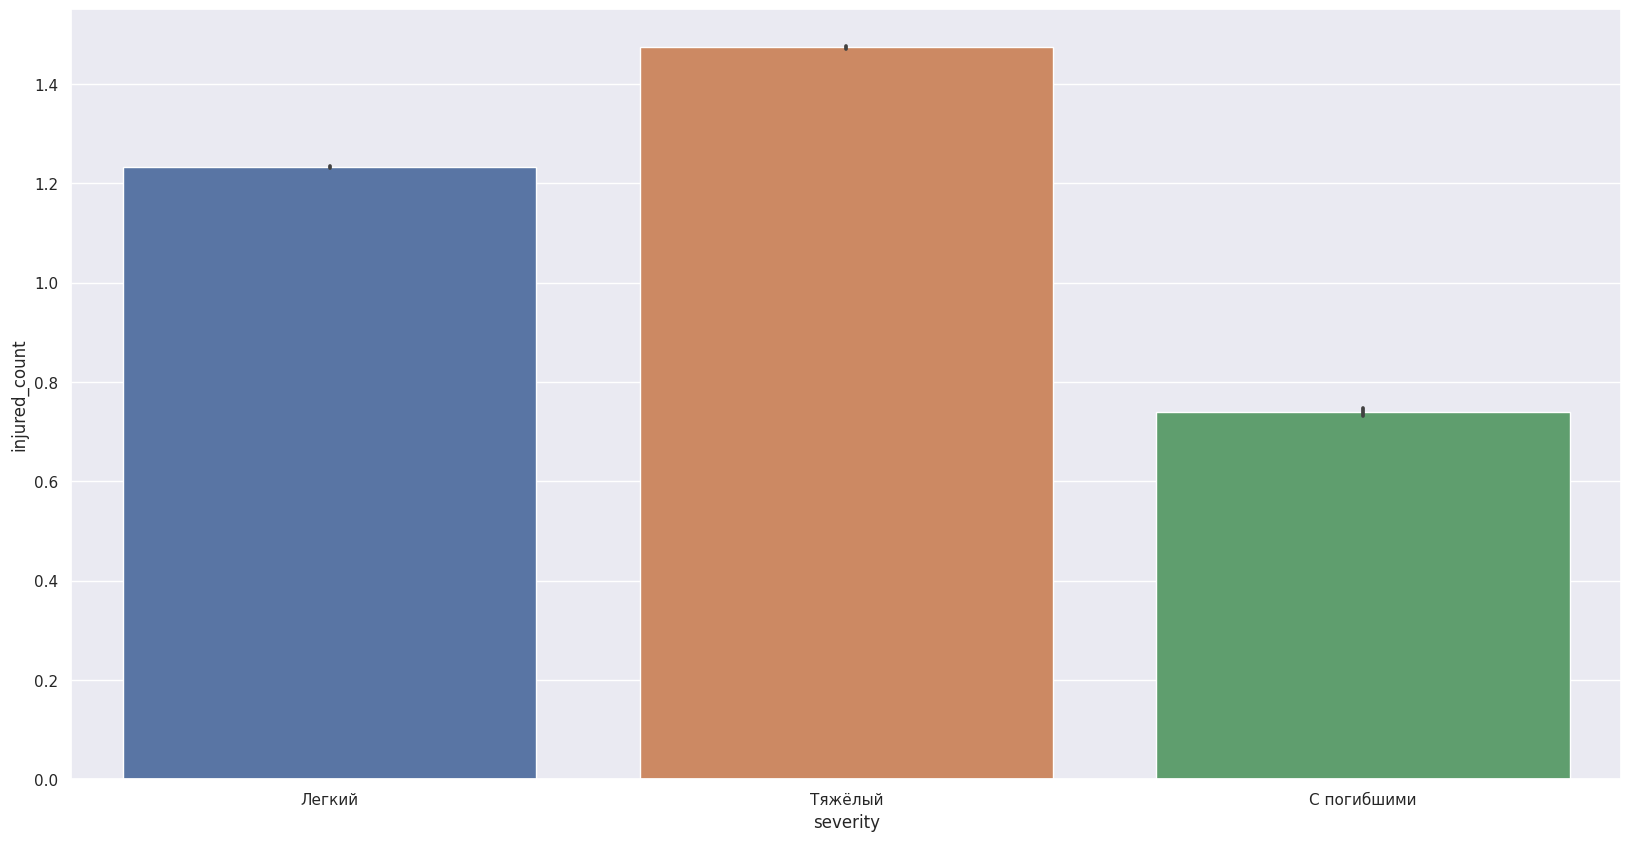

In [ ]:
sns.barplot(x='severity', y='injured_count', data=total_data_ready)

По графику можно заметить, что количество раненных больше всего было во время тяжелых случаев ДТП, потом в легких и в последнюю часть - с погибшими. Все логично, ведь во-первых, случаев с погибшими гораздо меньше по сравнению с остальными, во-вторых, во время таких ДТП люди чаще умирают, чем остаются раненными. Исходя их всего этого, тяжелые случаи ДТП содержат больше всего раненных людей, чем остальные

Следующий график - общее число участников ДТП к типу ДТП:

<Axes: xlabel='severity', ylabel='participants_count'>

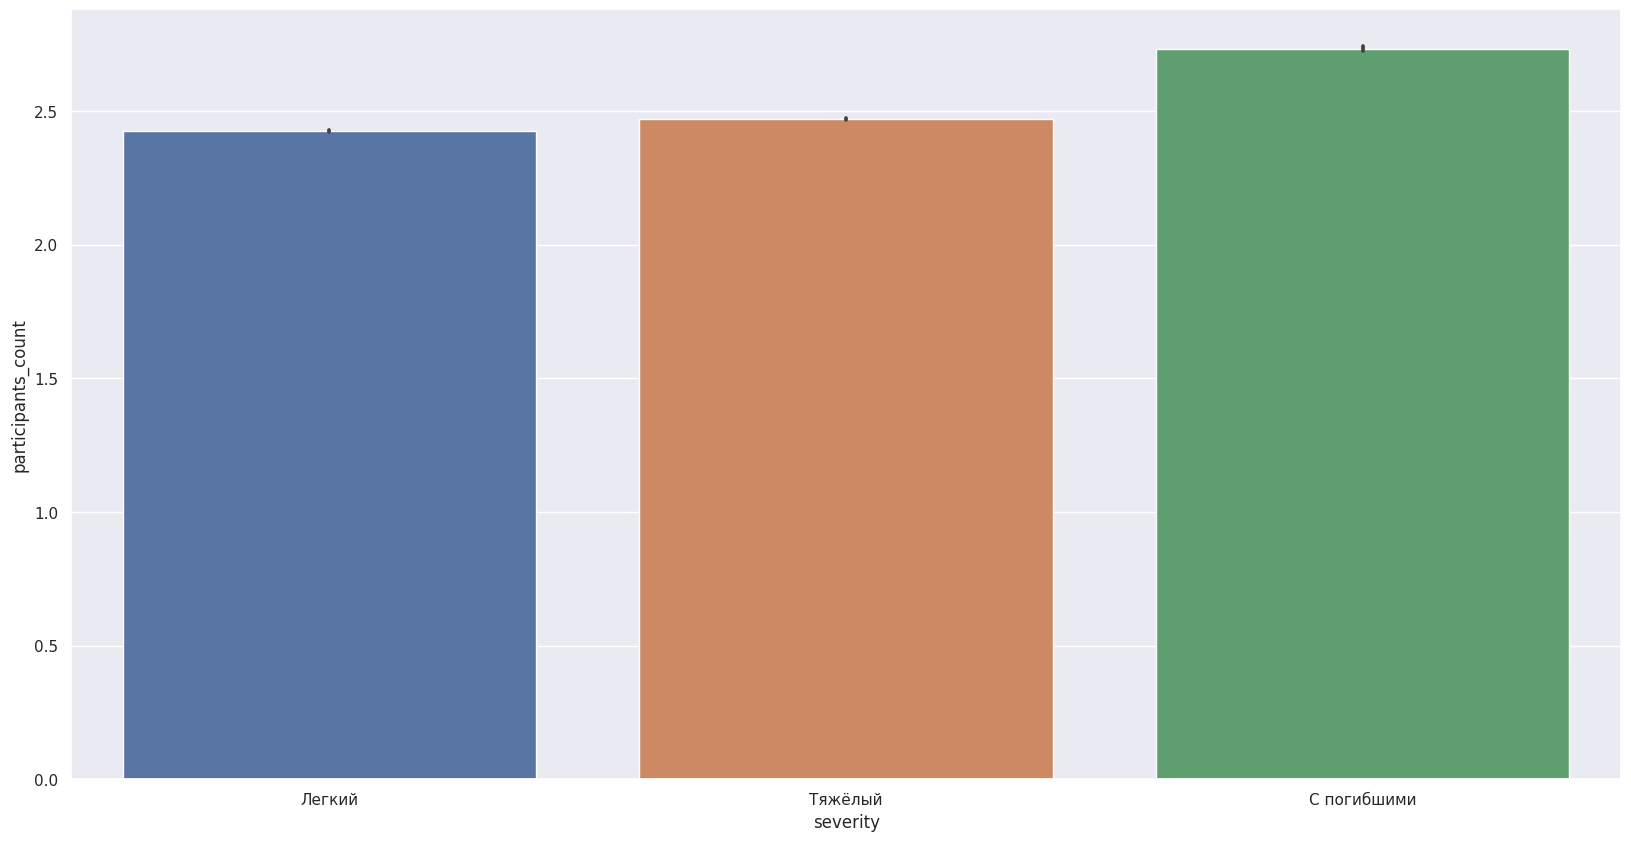

In [ ]:
sns.barplot(x='severity', y='participants_count', data=total_data_ready)

График выше показывает нам, что в случаях со смертельными исходами участвовало больше участников, чем в остальных. Все верно, ведь легкое ДТП чаще происходит с меньшим количеством участников (поэтому его и называют легким). Тяжелые случаи (без смертей) происходят с большим количеством раненных (как было показано в прошлом графике), но с таким же количество участников ДТП. А вот если происходят смертельные случаи, то это влечет за собой либо слишком большое количество участников и некоторые смерти, либо малое количество участников, но выше количества смертей.

Далее пойдут сводные таблицы, которые покажут численную разницу в количестве раненных к тяжести ДТП, уровню освещения и погоде:

In [ ]:
total_data_ready.head()

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,Сухое,2,Все участники,53.342000,83.690300
1,2589161,Дорожно-транспортные происшествия,Светлое время суток,"Остановка общественного транспорта, Нерегулиру...",Барнаул,"г Барнаул, ул Малахова, 46",Ясно,Столкновение,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,Все участники,53.369700,83.709200
2,2577125,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","Жилые дома индивидуальной застройки, Администр...",Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",Ясно,Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,Сухое,1,"Все участники, Мотоциклисты",53.264995,83.725905
3,2576909,Дорожно-транспортные происшествия,Светлое время суток,"Выезд с прилегающей территории, Административн...",Барнаул,"г Барнаул, ул Петра Сухова, 83 А",Ясно,Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,"Все участники, Мотоциклисты",53.376400,83.714200
4,2575209,Дорожно-транспортные происшествия,Светлое время суток,"Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Партизанская, 26",Ясно,Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,Все участники,53.343071,83.794366


In [ ]:
weather_to_injured = pd.pivot_table(total_data_ready, values='injured_count', index=['severity', 'light']
                                    , columns='weather'
                                    , aggfunc='sum')
weather_to_injured = weather_to_injured.fillna(0)
weather_to_injured

weather                                                    Дождь  \
severity    light                                                  
Легкий      В темное время суток, освещение включено     12103.0   
            В темное время суток, освещение не включено    387.0   
            В темное время суток, освещение отсутствует   3445.0   
            Не установлено                                   1.0   
            Светлое время суток                          18505.0   
            Сумерки                                       1213.0   
С погибшими В темное время суток, освещение включено       707.0   
            В темное время суток, освещение не включено     46.0   
            В темное время суток, освещение отсутствует   1135.0   
            Не установлено                                   0.0   
            Светлое время суток                           2526.0   
            Сумерки                                        111.0   
Тяжёлый     В темное время суток, освещение включено     10119.0   
            В темное время суток, освещение не включено    443.0   
            В темное время суток, освещение отсутствует   5037.0   
            Не установлено                                   0.0   
            Светлое время суток                          14163.0   
            Сумерки                                        980.0   

weather                                                  Дождь, Метель  \
severity    light                                                        
Легкий      В темное время суток, освещение включено               0.0   
            В темное время суток, освещение не включено            0.0   
            В темное время суток, освещение отсутствует            3.0   
            Не установлено                                         0.0   
            Светлое время суток                                    1.0   
            Сумерки                                                0.0   
С погибшими В темное время суток, освещение включено               0.0   
            В темное время суток, освещение не включено            0.0   
            В темное время суток, освещение отсутствует            2.0   
            Не установлено                                         0.0   
            Светлое время суток                                    7.0   
            Сумерки                                                0.0   
Тяжёлый     В темное время суток, освещение включено               1.0   
            В темное время суток, освещение не включено            0.0   
            В темное время суток, освещение отсутствует            2.0   
            Не установлено                                         0.0   
            Светлое время суток                                    2.0   
            Сумерки                                                0.0   

weather                                                  Дождь, Снегопад  \
severity    light                                                          
Легкий      В темное время суток, освещение включено                60.0   
            В темное время суток, освещение не включено              2.0   
            В темное время суток, освещение отсутствует             46.0   
            Не установлено                                           0.0   
            Светлое время суток                                    103.0   
            Сумерки                                                  9.0   
С погибшими В темное время суток, освещение включено                 4.0   
            В темное время суток, освещение не включено              0.0   
            В темное время суток, освещение отсутствует             13.0   
            Не установлено                                           0.0   
            Светлое время суток                                     23.0   
            Сумерки                                                  0.0   
Тяжёлый     В темное время суток, освещение включено                70.0   
            В темн

По таблице видно, что большее количество всех аварий происходило в ясную погоду в светлое время суток, поменьше в пасмурную погоду и еще меньше в дождливую погоду. Все логично, ведь ясная погода случается чаще всего, а это значит и больше времени для ДТП. Это означает, что, зачастую, на количество ДТП мало влияют посторонние факторы, такие как гололед.

In [ ]:
category_to_injured = pd.pivot_table(total_data_ready, values='injured_count', index='severity'
                                    , columns='category'
                                    , aggfunc='sum')
category_to_injured = category_to_injured.fillna(0)
category_to_injured

category,"Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.",Иной вид ДТП,Наезд на велосипедиста,Наезд на внезапно возникшее препятствие,Наезд на гужевой транспорт,Наезд на животное,"Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность","Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы","Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ",Наезд на пешехода,Наезд на препятствие,Наезд на стоящее ТС,Опрокидывание,Отбрасывание предмета,Падение груза,Падение пассажира,Столкновение,Съезд с дороги
severity,,,,,,,,,,,,,,,,,,
Легкий,46,3939,24914,202,99,2875,404,588,684,197959,44861,27258,42436,634,164,34190,444570,39086
С погибшими,2,162,217,23,37,303,19,8,94,3198,6039,3106,7835,22,14,17,61809,5335
Тяжёлый,45,1975,14002,103,171,2264,83,36,67,136935,46761,19699,54684,309,90,7374,295822,41821


По таблице видим, что чаще всего ДТП происходят при столкновении машин, наезде на пешехода и опрокидывании. Все эти признаки говорят о том, что либо виноваты водители, либо виноваты внешние факторы. Однако в прошлой таблице мы заметили влияние внешних факторов на количество ДТП и поняли - погода на ДТП влияет не сильно, что говорит о виновности самих водителей в ДТП.

In [ ]:
total_data_ready

,id,tags,light,nearby,region,address,weather,category,datetime,severity,dead_count,injured_count,parent_region,road_conditions,participants_count,participant_categories,lat,long
0,2311491,Дорожно-транспортные происшествия,"В темное время суток, освещение отсутствует","Многоквартирные жилые дома, Административные з...",Барнаул,"г Барнаул, тракт Павловский, 249 а",Ясно,Наезд на препятствие,2017-09-04 22:15:00,Легкий,0,1,Алтайский край,Сухое,2,Все участники,53.342000,83.690300
1,2589161,Дорожно-транспортные происшествия,Светлое время суток,"Остановка общественного транспорта, Нерегулиру...",Барнаул,"г Барнаул, ул Малахова, 46",Ясно,Столкновение,2021-06-29 16:45:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,Все участники,53.369700,83.709200
2,2577125,Дорожно-транспортные происшествия,"В темное время суток, освещение включено","Жилые дома индивидуальной застройки, Администр...",Барнаул,"г Барнаул, А-322 Барнаул - Рубцовск - граница ...",Ясно,Наезд на препятствие,2021-05-30 21:40:00,Тяжёлый,0,1,Алтайский край,Сухое,1,"Все участники, Мотоциклисты",53.264995,83.725905
3,2576909,Дорожно-транспортные происшествия,Светлое время суток,"Выезд с прилегающей территории, Административн...",Барнаул,"г Барнаул, ул Петра Сухова, 83 А",Ясно,Столкновение,2021-05-29 19:40:00,Тяжёлый,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",3,"Все участники, Мотоциклисты",53.376400,83.714200
4,2575209,Дорожно-транспортные происшествия,Светлое время суток,"Многоквартирные жилые дома, Жилые дома индивид...",Барнаул,"г Барнаул, ул Партизанская, 26",Ясно,Столкновение,2021-05-25 16:40:00,Легкий,0,1,Алтайский край,"Сухое, Отсутствие, плохая различимость горизон...",2,Все участники,53.343071,83.794366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242828,1871505,Дорожно-транспортные происшествия,Светлое время суток,Нету информации,Борисоглебский район,"ВОЩАЖНИКОВО-ВЕСКА-ЗАДУБРОВЬЕ, 1 км",Ясно,Съезд с дороги,2019-06-17 14:00:00,Тяжёлый,0,1,Ярославская область,Сухое,1,"Мотоциклисты, Все участники",57.419191,39.105191
1242829,1872990,"Дорожно-транспортные происшествия, ДТП и постр...",Светлое время суток,Нету информации,Борисоглебский район,"ЮРКИНО-РАМЕНЬЕ, 2 км",Ясно,Съезд с дороги,2016-04-15 17:00:00,Тяжёлый,0,2,Ярославская область,Сухое,6,"Дети, Все участники",57.414200,39.200000
1242830,1867222,Дорожно-транспортные происшествия,Светлое время суток,Нету информации,Борисоглебский район,"УГЛИЧ-РОСТОВ, 76 км",Ясно,Столкновение,2019-07-13 19:30:00,Легкий,0,2,Ярославская область,Сухое,2,Все участники,57.230133,39.213767
1242831,1874000,Дорожно-транспортные происшествия,Светлое время суток,Нету информации,Борисоглебский район,"БОРИСОГЛЕБ-ЗАЧАТЬЕ, 1 км",Ясно,Опрокидывание,2018-08-15 17:00:00,Тяжёлый,0,1,Ярославская область,Сухое,1,Все участники,57.316100,39.004700


In [ ]:
# Смотрим на пропуски в данных
print("Number of missing values in train dataset:")
print(total_data_ready.isna().sum())

Number of missing values in train dataset:
id                            0
tags                          0
light                         0
nearby                        0
region                        0
address                       0
weather                       0
category                      0
datetime                      0
severity                      0
dead_count                    0
injured_count                 0
parent_region                 0
road_conditions               0
participants_count            0
participant_categories        0
lat                       10742
long                      10742
dtype: int64


Визуализируем пропуски в данных

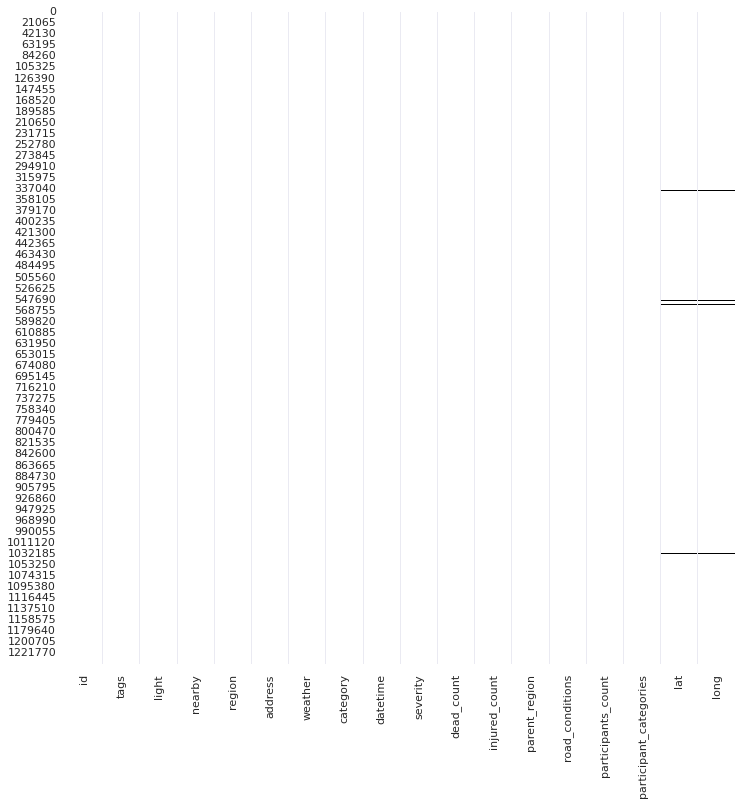

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(total_data_ready.isnull(), cbar = False, cmap = 'Greys')
plt.show()

Пропусков немного в ширине и долготе, так что не так страшно

# Выводы по сессии

По итогам данной сессии мы запарсили данные, обработали их, и сделали выводы. А именно:

загружены данные с официального сайта dtp-stat.ru . Данные были предобработаны: извлечены со словарей и списков, заменены типы данных и проверены на уникальность аварий. Описали данные и сделали выводы, которые помогут нам в следующей сессии по кластеризации.  Мы не выполнили работу по программированию промобота, так как у нас нет к нему доступа.

# Если будет время сделать отчет с форматом Data.zip!!!